<a href="https://colab.research.google.com/github/anshika0601/pytorchz-learn/blob/main/Day13/DataAugmentationandregularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torchvision.transforms as transforms


# No augmentation (just convert to tensor)
original_transform = transforms.Compose([
    transforms.ToTensor()
])

# With augmentation (example: CIFAR-10 style)
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.7),     # 70% chance of flipping
    transforms.RandomRotation(degrees=20),      # rotate between -20 and +20
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor()
])

# Test pipeline (no augmentation, just normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])


In [4]:
#loading dataset
from torchvision.datasets import CIFAR10

train_actual_dataset = CIFAR10(root='./data', train=True, download=True, transform=original_transform)
train_augment_dataset = CIFAR10(root='./data', train=True, download=True, transform=augmented_transform)
test_dataset  = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

from torch.utils.data import DataLoader

train_actual_loader = DataLoader(train_actual_dataset, batch_size=128, shuffle=True, num_workers=2)
train_augment_loader = DataLoader(train_augment_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


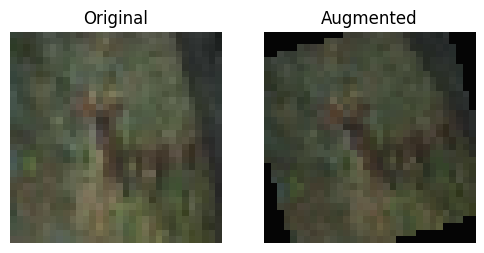

In [5]:
#visualize augmented vs original image
import matplotlib.pyplot as plt
# Get a single image
idx = 10
img_original, label = train_actual_dataset[idx]
img_augmented, _ = train_augment_dataset[idx]

# Convert from Tensor (C,H,W) to numpy (H,W,C) for plotting
def imshow(img):
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')

# Plot
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
imshow(img_original)
plt.title("Original")

plt.subplot(1,2,2)
imshow(img_augmented)
plt.title("Augmented")

plt.show()


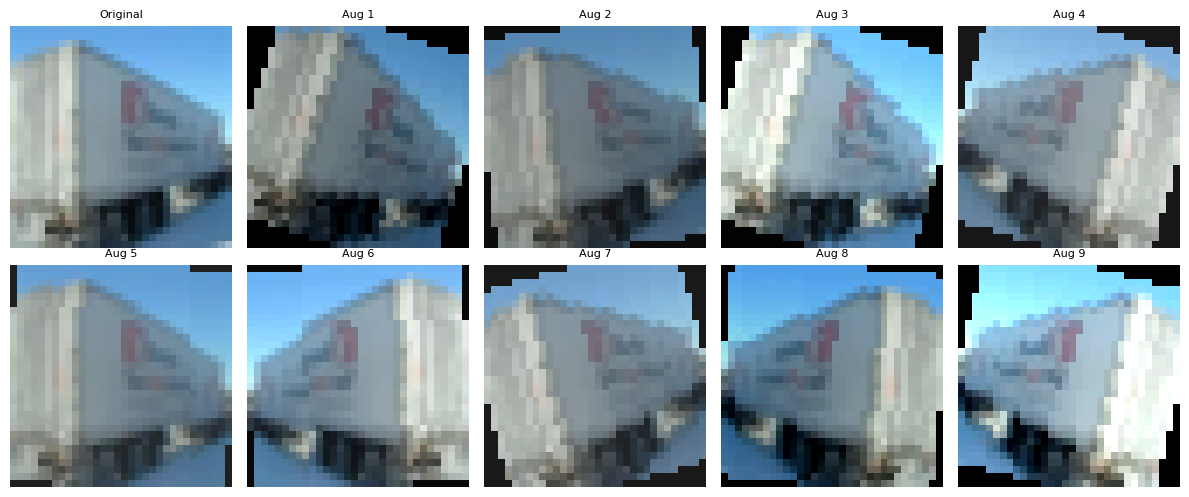

In [6]:
#visualize original and how diff augmentation affect original

# Pick one sample image
idx = 15
img_original, label = train_actual_dataset[idx]

# Function to convert tensor -> numpy for plotting
def imshow(img, ax, title=None):
    img = img.permute(1, 2, 0).numpy()   # CHW -> HWC
    ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=8)

# --- Plot Original + Multiple Augmentations ---
fig, axes = plt.subplots(2, 5, figsize=(12,5))

# First plot: original
imshow(img_original, axes[0,0], title="Original")

# Next 9 plots: augmented versions
for i in range(9):
    img_aug, _ = train_augment_dataset[idx]   # apply augmentation
    row, col = divmod(i+1, 5)
    imshow(img_aug, axes[row, col], title=f"Aug {i+1}")

plt.tight_layout()
plt.show()


In [8]:
#model
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*8*8, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [9]:
#train and validation loop
import torch
import torch.optim as optim

def train_model(trainloader, name="No Augmentation"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    for epoch in range(5):  # keep short for demo
        net.train()
        running_loss, correct, total = 0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100.*correct/total

        # validation
        net.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_acc = 100.*val_correct/val_total

        print(f"[{name}] Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    return net

# Train two models
model_no_aug = train_model(train_actual_loader, name="No Augmentation")
model_aug = train_model(train_augment_loader, name="With Augmentation")


[No Augmentation] Epoch 1: Train Acc=46.01%, Val Acc=29.59%
[No Augmentation] Epoch 2: Train Acc=59.72%, Val Acc=34.62%
[No Augmentation] Epoch 3: Train Acc=65.16%, Val Acc=39.55%
[No Augmentation] Epoch 4: Train Acc=68.99%, Val Acc=41.55%
[No Augmentation] Epoch 5: Train Acc=72.04%, Val Acc=42.12%
[With Augmentation] Epoch 1: Train Acc=40.52%, Val Acc=39.90%
[With Augmentation] Epoch 2: Train Acc=52.42%, Val Acc=47.03%
[With Augmentation] Epoch 3: Train Acc=57.11%, Val Acc=52.36%
[With Augmentation] Epoch 4: Train Acc=60.19%, Val Acc=54.17%
[With Augmentation] Epoch 5: Train Acc=62.99%, Val Acc=54.31%
